**This was written in Python 2, if you are running Python 3, use a code translation library.**

The cell include all imports, dir path, and some function definitions

In [16]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date, time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math

%matplotlib inline
#This is graph line style, from Nate silver
plt.style.use('fivethirtyeight')

#This is for the interactive plotting using bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models.markers import Asterisk
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid
from bokeh.models import HoverTool

#My mac directory path
_DATA_DIR = r'/Users/schem001/Desktop/Diabetes Project/Diabetic-Project/input'
_FIG_DIR = r'/Users/schem001/Desktop/Diabetes Project/Diabetic-Project/figures'

#My win directory path
# _DATA_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\Input\input'
# _FIG_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\figures'

if not os.path.exists(_FIG_DIR):
    os.makedirs(_FIG_DIR)
    
_GULCOSE_DATA_PATH = os.path.join(_DATA_DIR, 'P1.csv')
fields = ["Date", "mg/dL", "CHO (g)", "Fat (g)", "Protein (g)"]
df_P = pd.read_csv(_GULCOSE_DATA_PATH, parse_dates=['Date'], usecols = fields) #read and prase Date col as dataTimes object
df_P = df_P.sort_values(['Date'])

## Matplotlib Variables
_FIG_SIZE = (16, 8)
_FIG_FORMAT = 'png'
_FIG_DPI = 200

def _file_format(string_):
    string_ = string_.replace('-', '_').replace(' ', '_').replace('$', '')
    string_ += '.' + _FIG_FORMAT
    return string_

#For printing full elements of dataframe or array
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

This cell fetches data from the file, stores all glucose readings in a dataframe, as well as the recorded meals into a different dataframe. It also combines meals that are close to each other into one.

Final dataframe with all the BG readings is:  df_Pv2

Final datafraem with all meal recordings is: df_P_meals


Total number of glucose readings for this patient is: 7633

Some recordings inbetween may be missing, the above number represents the collected readings from start to end date

Remove NaN from the mg/dL column... 
Total actual number of glucose readings is: 6092

-------------------------------------------

Number of meals recorded is: 253

Some of the successive meal readings stand for one meal with many servings.

Add succesive meal readings (CHO, fat, protein) and store under one recording...

There is a total of 91 recorded meals.

Printing the head of meal dataframe...

                 Date  mg/dL  CHO (g)  Fat (g)  Protein (g)
0 2008-07-01 09:43:00   82.0    55.00     0.00        14.00
1 2008-07-01 12:43:00   54.0    58.00    11.00        13.50
2 2008-07-01 14:58:00   86.0     7.00     0.00         5.00
3 2008-07-01 17:58:00   88.0    47.33    18.02        16.62
4 2008-07-02 08:58:00   99.0    55.00     0.00        14.00


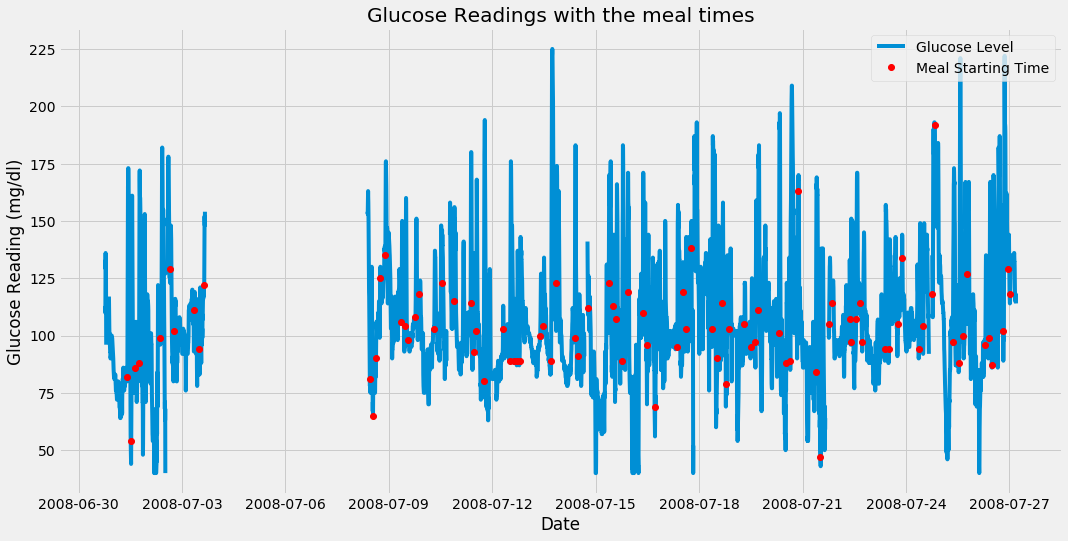

In [17]:
#Task 1
print "\nTotal number of glucose readings for this patient is:", df_P['mg/dL'].size
print "\nSome recordings inbetween may be missing, the above number represents the collected readings from start to end date"

#Removing NaN from a specific column of the dataframe, here it's mg/dL
df_P_wonan_mg = df_P.dropna(subset=['mg/dL'])
print "\nRemove NaN from the mg/dL column...", "\nTotal actual number of glucose readings is:", df_P_wonan_mg['mg/dL'].size

#Converting object type to float for all of the dataframe (df_Pv2 stands for dataframe, patient, version 2)
df_Pv2= pd.DataFrame(df_P_wonan_mg).convert_objects(convert_numeric=True)

#Task 2
print "\n-------------------------------------------"
#Get Meal dataframe

#print "\nRemove NaN from the CHO so we can plot the points of meals..."
df_Pv2 = df_Pv2.dropna(subset=['CHO (g)'])
print "\nNumber of meals recorded is:", df_Pv2['CHO (g)'].size
print "\nSome of the successive meal readings stand for one meal with many servings."

df_Pv2 = df_Pv2.reset_index(drop=True)

df_P_meals = copy.deepcopy(df_Pv2)

print '\nAdd succesive meal readings (CHO, fat, protein) and store under one recording...' 

#Task 3
#Combine the successive meals: if the minute difference is 5 minutes then combine
row = 0
i = 0   
while (i < (df_Pv2['CHO (g)'].size-1)):
    k = i
    row = row + 1         
   
    minutesdiff = df_Pv2.Date[k+1] - df_Pv2.Date[k]
    
    #If the meals are within 30 minutes of each other, combine into one
    while ((minutesdiff.seconds / 60 <= 30)):
        #drop this row but add CHO and fats and proteins to values of previous row
        k = k+1
        df_P_meals.set_value(row-1,'CHO (g)',df_P_meals['CHO (g)'][row-1]+df_P_meals['CHO (g)'][row])
        df_P_meals.set_value(row-1,'Fat (g)',df_P_meals['Fat (g)'][row-1]+df_P_meals['Fat (g)'][row])
        df_P_meals.set_value(row-1,'Protein (g)',df_P_meals['Protein (g)'][row-1]+df_P_meals['Protein (g)'][row])
        df_P_meals.drop(df_P_meals.index[row], axis=0, inplace=True)
        df_P_meals = df_P_meals.reset_index(drop=True)
        if (k == (df_Pv2['CHO (g)'].size-1)):
            break   
        minutesdiff = df_Pv2.Date[k+1] - df_Pv2.Date[k]
    i = k+1               

df_P_meals = df_P_meals.reset_index(drop=True)
print "\nThere is a total of", df_P_meals['CHO (g)'].size, "recorded meals.\n" 

print "Printing the head of meal dataframe...\n\n", df_P_meals.head()

plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df_P.Date, df_P['mg/dL'], '-', label="Glucose Level");
plt.plot_date(df_P_meals.Date, df_P_meals['mg/dL'], 'ro', label="Meal Starting Time")
plt.xlabel('Date')
plt.ylabel('Glucose Reading (mg/dl)')
plt.legend(loc='upper right')
title = 'Glucose Readings with the meal times'
plt.title(title);

#For later use, maybe
#Last non empty row of patient data
nonempty_P_readings = df_P[pd.notnull(df_P['Date'])]
nonempty_readings = df_P[pd.notnull(df_P['Date'])]
last_row_date = nonempty_readings.iloc[-1, nonempty_readings.columns.get_loc('Date')]

This cell outputs an interactive plot, where we can zoom in and out and select a specific area.

In [18]:
#output to static HTML file
output_file("Raw_CGM.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Readings Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P.Date, df_P['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P.Date, df_P['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P_meals.Date, y=df_P_meals['mg/dL'], z=df_P_meals['CHO (g)'], k = df_P_meals['Fat (g)'], d = df_P_meals['Protein (g)']))

g1 = plot.asterisk(x=df_P_meals.Date, y=df_P_meals['mg/dL'], legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "BG Concentration (mg/dL)"

show(plot) 

## Current patient meal size histogram & Stats

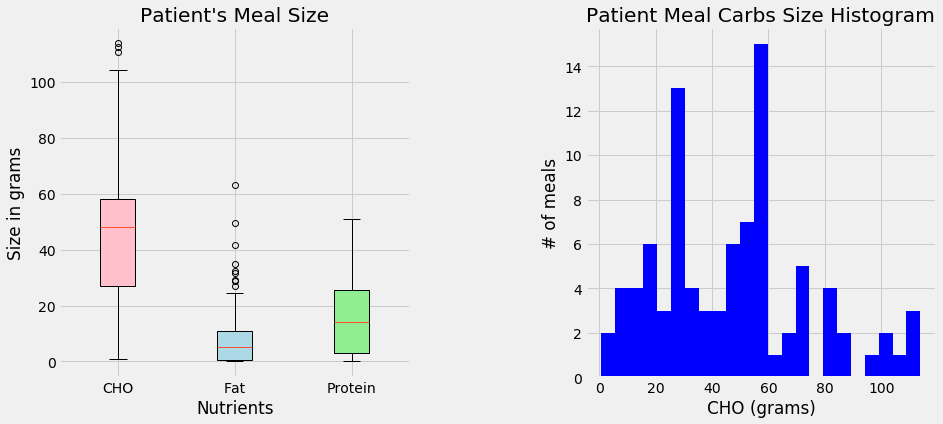

For this patient, the meal Carbs mean is: 47.12 grams with a std of: 26.74 grams.


In [19]:
bins =  int(math.ceil(np.max(df_P_meals['CHO (g)'])/5))#bins of 5 grams

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
######################Box Plot
# rectangular box plot
bplot1 = axes[0].boxplot([df_P_meals['CHO (g)'],df_P_meals['Fat (g)'], df_P_meals['Protein (g)']],
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)
# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# add x-tick labels
plt.setp(axes[0], xticks=[y+1 for y in range(3)],
         xticklabels=['CHO', 'Fat', 'Protein'])

axes[0].set_xlabel('Nutrients')
axes[0].set_ylabel('Size in grams')
axes[0].set_title('Patient\'s Meal Size')

#####################Histogram of CHO
bplot0 = axes[1].hist(df_P_meals['CHO (g)'], bins, facecolor='blue', alpha=1)
axes[1].set_xlabel('CHO (grams)')
axes[1].set_ylabel('# of meals')
axes[1].set_title('Patient Meal Carbs Size Histogram')
fig.subplots_adjust(wspace=0.5)

plt.show()

#n, bins, patches = plt.hist(df_P_meals['CHO (g)'], bins, facecolor='blue', alpha=1)

print "For this patient, the meal Carbs mean is:", round(np.mean(df_P_meals['CHO (g)']),2), "grams with a std of:",round(np.std(df_P_meals['CHO (g)']),2), "grams."

#  Assumptions for Cleaning Data

In [20]:
print "\nData Cleaning...\n"


Data Cleaning...



**a. Remove meals that have several missing BG readings within their postprandial period**

We may consider keeping these points later if we are interested on the meal times only and not their postprandial signals.

The selected window is under window_size_minutes. i.e: 23 represents a window of (23*5)+5 = 120 mintues

In [21]:
print "\n-------------Condition 1-------------------"
print "\nRemove meal points which have several missing BG readings in their postprandial window...\n"

#This chunk of code implements the first condition, which removes the meals that have significant missing successive points
import datetime

df_P_meals_w_deletion = copy.deepcopy(df_P_meals)

#variables
incr = 5 #Data was recorded at 5 minutes increments
#window_size = 23 #This represents window size based on increments of 5.

window_size_minutes = 180# in minutes
window_size = (window_size_minutes / 5) - 1

del_points_df_a = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
points_to_del_a = []

for x in range(df_P_meals_w_deletion['CHO (g)'].size):
    a = df_P_meals_w_deletion['Date'][x]
    b = a
    count = 0
    for j in range(window_size):
        b += datetime.timedelta(minutes=incr)
        reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        try:
            reading.values[0]
        except IndexError:
            #print "Index out of range"
            count +=1 
            continue  
        if (math.isnan(reading.values[0])):
            count +=1
    #If eighth of the window size has missing values, exclude that meal
    if (count > ((window_size+1)/8)):
        print "\nThe meal at", a, "has", count,"missing readings within its following {}".format((window_size+1)*5),"minutes. Thus, it will be removed."
        #Put this into a dataframe to plot later with different color
        del_points_df_a = del_points_df_a.append(df_P.loc[df_P['Date'] == a])        
        points_to_del_a.extend([x])  

#Remove the above detected points from dataset
df_P_meals_w_deletion.drop(df_P_meals_w_deletion.index[points_to_del_a],axis=0,inplace=True)
df_P_meals_w_deletion = df_P_meals_w_deletion.sort_values(['Date'])
df_P_meals_w_deletion = df_P_meals_w_deletion.reset_index(drop=True)

if (df_P_meals_w_deletion['CHO (g)'].size == df_P_meals['CHO (g)'].size):
    print "There are no meals that need to be excluded, at this stage.\n"

print "There are", df_P_meals_w_deletion['CHO (g)'].size, "remaining meal times recordings.\n" 


-------------Condition 1-------------------

Remove meal points which have several missing BG readings in their postprandial window...


The meal at 2008-07-03 15:28:00 has 29 missing readings within its following 180 minutes. Thus, it will be removed.

The meal at 2008-07-17 18:38:00 has 7 missing readings within its following 180 minutes. Thus, it will be removed.
There are 89 remaining meal times recordings.



**b. Delete meals which do not have a significant BG increase in their postprandial signal (i.e: 15mg/dl).**

**We are defining a postprandial signal to be between the meal time until the second point of significant increase, which is most likely the next meal**

*The following is optional (change variable in code to include): We start few minutes before the meal was recorded, just in case the meal was recorded few minutes after food intake.

For instance, a reading situated 30 minutes after meal time recording which has a following glucose increase of (15mg/dl in total) after 30minutes will result on keeping that original meal time which was (30mins + 30mins before). Hence, this is a loose assumption but we can make it stricter by changing window variables and increase glucose value.

If no significant increase is apparent, we delete the meal point.

In [22]:
print "\n-------------Condition 2-------------------"
print "\nRemove meal points which do NOT have a significant BG increase in their postprandial window...\n"

#This chunk of code implements the second constraint, removing meals which do not have a significant postprandial glucose increase
df_P_meals_w_deletion_b = copy.deepcopy(df_P_meals_w_deletion)

incr = 5 #Data was collected at 5 minutes increments- Do not change this
glucose_effect_window = 45 #Minutes food may take to be reflected on the blood glucose
#Change below to higher minutes if glucose increases slowly
gl_increase_window = 30 #Minutes from the instance where the glucose is reflected on the blood to significant increase
pre_recording_mins = 0 #Minutes that may have elapsed before patient has recorded the reading
gl_increase = 15 #15mg/dL increase because we are interested in meals for now, later we can include sncaks

#May want to change VARIABLES above for different patients, especially if food takes a while to affect their glucose level

meal_affect_window = [i for i in np.arange(-(pre_recording_mins), glucose_effect_window+incr, incr)]

compare_window = [j for j in np.arange(incr, gl_increase_window+incr, incr)]

points_to_del_b = []
del_points_df_b = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
low_surrounding_gl = pd.DataFrame()#Dataframe containing points where the glucose will go to take a significant increase, not necessarily the very lowest points
high_surrounding_gl = pd.DataFrame()
offset_low_point_to_meal = []

for x, item in enumerate(df_P_meals_w_deletion_b['Date']):
    
    a = df_P_meals_w_deletion_b['Date'][x]
    meal_reading = df_P.loc[df_P['Date'] == item]['mg/dL']
    b = item - datetime.timedelta(minutes=pre_recording_mins) 
    keep = 0
    
    for i in meal_affect_window:
        current_reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        try:
            current_reading.values[0]
        except IndexError:
            #print "Index out of range"
            b += datetime.timedelta(minutes=incr)   
            continue            
        if (math.isnan(current_reading.values[0])):
            b += datetime.timedelta(minutes=incr)  
            continue      
            
        c = b
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P.loc[df_P['Date'] == c]['mg/dL']
            if ((compare_reading.values[0] - current_reading.values[0]) >=gl_increase):
                #Store this reading on a dataframe of low readings surrounding meals
                low_surrounding_gl = low_surrounding_gl.append(df_P.loc[df_P['Date'] == b])
                high_surrounding_gl = high_surrounding_gl.append(df_P.loc[df_P['Date'] == c])
                #print "a is:", a, "and b is:", b, "and c is:", c, "and difference between b and c is:", (c - b)
                if (b<item):
                    offset_low_point_to_meal.extend([int(-(item-b).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "-", (a-b).seconds / 60 ,"minutes."        
                else:
                    offset_low_point_to_meal.extend([int((b-item).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "+", (b-a).seconds / 60 ,"minutes."  
                #offset_low_point_to_meal.extend([offset_seconds])
                keep = 1  
                break
                
        if (keep == 1):
            break
        b += datetime.timedelta(minutes=incr)    
        
        if (i == meal_affect_window[-1]):
            #print "The meal reading taken at" ,a, "should be deleted."            
            #print "The reading that is about to be removed has the following size, CHO", round(df_P_meals_w_deletion_b['CHO (g)'][x],2),"g, Proteins", round(df_P_meals_w_deletion_b['Protein (g)'][x],2),"g, Fats", round(df_P_meals_w_deletion_b['Fat (g)'][x],2),"g"
            
            #Put this into an dataframe to plot with different color
            del_points_df_b = del_points_df_b.append(df_P.loc[df_P['Date'] == item])
            #Also remove this from dataset   
            points_to_del_b.extend([x]) 

#Switch to this part of the code            
##Add this portion of the code if we want to keep all meals that are above a certain treshold and do not meet the above condition
#             #if the meal size is larger than certain value, keep regardless. For instance, cho > 20grams, or proteins > 10grams, or fats > 10 grams        
#             if(df_P_meals_w_deletion_b['CHO (g)'][x]>20 or df_P_meals_w_deletion_b['Protein (g)'][x]>10 or df_P_meals_w_deletion_b['Fat (g)'][x]>10):
#                 break
#             else:
#                 #Put this into an dataframe to plot with different color
#                 del_points_df_b = del_points_df_b.append(df_P.loc[df_P['Date'] == item])
#                 #Also remove this from dataset   
#                 points_to_del_b.extend([x])      
#############################################################

#print "\nThe dataframe of the points to be deleted is:\n", del_points_df 
#print (points_to_del)

print "\nThere are", len(points_to_del_b), "meal recordings that will be deleted after this condition."

df_P_meals_w_deletion_b.drop(df_P_meals_w_deletion_b.index[points_to_del_b],axis=0,inplace=True)
df_P_meals_w_deletion_b = df_P_meals_w_deletion_b.sort_values(['Date'])
df_P_meals_w_deletion_b = df_P_meals_w_deletion_b.reset_index(drop=True)

print "\nThere are", df_P_meals_w_deletion_b['CHO (g)'].size, "remaining meal times recordings.\n" 

low_surrounding_gl = low_surrounding_gl.sort_values(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

high_surrounding_gl = high_surrounding_gl.sort_values(['Date'])
high_surrounding_gl = high_surrounding_gl.reset_index(drop=True)

df_P_meals_w_deletion_v2 = copy.deepcopy(df_P_meals_w_deletion_b)


-------------Condition 2-------------------

Remove meal points which do NOT have a significant BG increase in their postprandial window...


There are 12 meal recordings that will be deleted after this condition.

There are 77 remaining meal times recordings.



In [23]:
# output to static HTML file, remaining meals, meals to be deleted after assumption a and b
output_file("All_Data_with_Deletion.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Readings Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P.Date, df_P['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P.Date, df_P['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], z=df_P_meals_w_deletion_v2['CHO (g)'], k = df_P_meals_w_deletion_v2['Fat (g)'], d = df_P_meals_w_deletion_v2['Protein (g)']))
g1 = plot.asterisk(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

if (len(points_to_del_a) != 0):
    plot.asterisk(x=del_points_df_a.Date, y=del_points_df_a['mg/dL'],legend = 'Meal to be deleted after condition a', line_color="#32CD32", fill_color=None, line_width=8)

if (len(points_to_del_b) != 0):    
    plot.asterisk(x=del_points_df_b.Date, y=del_points_df_b['mg/dL'],legend = 'Meal to be deleted after condition b', line_color="#0404B4", fill_color=None, line_width=8)

#plot.asterisk(x=high_surrounding_gl.Date, y=high_surrounding_gl['mg/dL'], legend = 'first increase Points', line_color="#32CD32", fill_color=None, line_width=8)   
#plot.asterisk(x=low_surrounding_gl.Date, y=low_surrounding_gl['mg/dL'], legend = 'first low Points', line_color="#0404B4", fill_color=None, line_width=8)   

#print y
plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "BG Concentration (mg/dL)"

show(plot) 


**The dataframe that contains the meal times after deletion of abnormal meal recordings is: df_P_meals_w_deletion_v2**

## Detecting postprandial peaks

Steps:

1. Detect a significant glucose drop. 

2. Find the highest glucose point up to that drop point

3. If a significant drop was not found after the postprandial peak, remove that meal point


In [24]:
print "\n-------------Condition 3-------------------"
print "\nRemove meal points which do NOT have a significant BG decrease following their postprandial peak...\n"

#Step 1

gl_decrease = 15 #15mg/dl of glucose drop (we noticed from the data that 10mg/dl would be too low and may result in not finding the highest peak after meal)

minutes2peak = 60#Minutes to reach the peak after highest surrounding point detected before
gl_decrease_window = 90 #Minutes it takes for a significant glucose decrease after meal, it may take long time for glucose to go down, few hours

up2peak_window = [j for j in np.arange(0, minutes2peak+incr, incr)]
compare_window = [j for j in np.arange(incr, gl_decrease_window+incr, incr)]

#print up2peak_window

afterpeak_lowgl_df = pd.DataFrame()#This dataframe contains the points after the glucose drop following the peak
lowpoint_to_del_df = pd.DataFrame()#Dataframe contaning any meal recording to be deleted because they do not have a significant nearby glucose drop after the increase
peak_points_df = pd.DataFrame()#Dataframe containing peak points following meal times
lowpoint_to_del = []

for x, item in enumerate(high_surrounding_gl['mg/dL']):   
    a = high_surrounding_gl['Date'][x]   
    keep = 0
    b= a

    for i in up2peak_window:
        current_reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        #print "**Following reading:", current_reading.values[0], "at the date of", b          
        c = b
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P.loc[df_P['Date'] == c]['mg/dL']
            #print "***Compared reading:", compare_reading.values[0], " at the date of", c  
            if ((current_reading.values[0] - compare_reading.values[0]) > gl_decrease):#significant glucose drop has been detected
                #Store this reading on a dataframe of points detecting glucose drop after peak
                afterpeak_lowgl_df = afterpeak_lowgl_df.append(df_P.loc[df_P['Date'] == c])
                keep = 1
                break
                
        if (keep == 1):
            break   
    
        if (i == up2peak_window[-1]):
            #print "Could not detect a significant glucose drop after this meal recording", df_P_meals_w_deletion_v2['Date'][x], ". It is suggested to delete it"  
            lowpoint_to_del.extend([x])  
            lowpoint_to_del_df = lowpoint_to_del_df.append(df_P.loc[df_P['Date'] == a])
            
        b += datetime.timedelta(minutes=incr)    

afterpeak_lowgl_df = afterpeak_lowgl_df.reset_index(drop=True)
lowpoint_to_del_df = lowpoint_to_del_df.reset_index(drop=True)

#step 3
print "Could not detect a significant glucose drop after the following meal recordings:\n\n",lowpoint_to_del_df['Date']
#Drop x from the "all the meals" dataframe 
df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[lowpoint_to_del],axis=0,inplace=True)  
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)

#print "number of meals are:", df_P1_meals_w_deletion['CHO (g)'].size

#print "afterpeak_lowgl_df size is:", afterpeak_lowgl_df['CHO (g)'].size

#Step 2

#print "\nThe dataframe of the points after detecting a glucose drop:\n", afterpeak_lowgl_df 
def drange(start, stop, step):
    while start <= stop:
            yield start
            start += step
            
for x, item in enumerate(afterpeak_lowgl_df['mg/dL']):
    #print "At the meal of date", df_P1_meals_w_deletion['Date'][x], "the lowest point is at:", surrounding_lowest_points_df['Date'][x] , "and low after peak is at:", afterpeak_lowgl_df['Date'][x]  
    a = df_P_meals_w_deletion_v2['Date'][x]
    #print "x is:", x , "and its date is:", afterpeak_lowgl_df['Date'][x]   
    current_reading = df_P.loc[df_P['Date'] == a]['mg/dL'].values[0]
    lowpt_after_peak = afterpeak_lowgl_df['Date'][x]   
    b= a
    #difference in minutes between lowest point and the point after glucose drop following peak
    window_peak = (lowpt_after_peak-a).seconds / 60
    #print window_peak
    peak_index = 0

    for i in drange(5,window_peak,5):        
        b += datetime.timedelta(minutes=incr)
        if (b <= nonempty_P_readings.iloc[-1,nonempty_P_readings.columns.get_loc('Date')]):
            incrt_reading = df_P.loc[df_P['Date'] == b]['mg/dL'].values[0]   
            if (math.isnan(incrt_reading)):
                b += datetime.timedelta(minutes=incr)  
                continue

            if (incrt_reading > current_reading):
                current_reading = incrt_reading
                peak_index = i
    #print "the peak index is offseted by", peak_index, "minutes from the lowest reading"        
    c = a + datetime.timedelta(minutes=int(peak_index))
    
    peak_points_df = peak_points_df.append(df_P.loc[df_P['Date'] == c])

peak_points_df = peak_points_df.reset_index(drop=True)

#print_full(peak_points_df['Date'])  

#print_full(surrounding_lowest_points_df)

#print peak_points_df 

#print peak_points_df[0:1]

peak_elapsed_time = []

#Need to make list with elapsed time between peak and meal recording for plotting, in minutes
for x, item in enumerate(peak_points_df['mg/dL']): 
    meal_recording = df_P_meals_w_deletion_v2['Date'][x]
    peak_reading = peak_points_df['Date'][x]      
    if (peak_reading>=meal_recording):
        topeakduration = (peak_reading-meal_recording).seconds / 60
    else:
        topeakduration = -(meal_recording-peak_reading).seconds / 60
        #This case should not happen
        
    #print "Duration between the meal and peak is :",topeakduration
    peak_elapsed_time.append(int(topeakduration))
    
print "\nThere are", df_P_meals_w_deletion_v2['Date'].size, "total remaining readings."


-------------Condition 3-------------------

Remove meal points which do NOT have a significant BG decrease following their postprandial peak...

Could not detect a significant glucose drop after the following meal recordings:

0   2008-07-08 15:13:00
1   2008-07-23 18:38:00
2   2008-07-27 00:53:00
Name: Date, dtype: datetime64[ns]

There are 74 total remaining readings.


Making sure that two meals are not close enough to each other. If they are, we keep only the second one while adding both meal sizes. 

1. Detect the peak points of the same date.

2. Add the meals of those dates.

3. Keep the first one and delete rest.

In [25]:
print "\nFor meal recordings that are close enough and end up having the same peak, remove the latest and keep the first. However, add the meal sizes together.\n"

remove_index = peak_points_df['Date'].size #setting this to some value it will never be so we can overwrite it later
remove_pts = []
remove_pts_2 = []
for i in range(peak_points_df['Date'].size):
    if ((i < peak_points_df['Date'].size -1) and (peak_points_df['Date'][i] == peak_points_df['Date'][i+1]) and (i != remove_index) and (((df_P_meals_w_deletion_v2['Date'][i+1]- (df_P_meals_w_deletion_v2['Date'][i])).seconds / 60) <30)):
        print "There are two meal readings which have the same peak.", "The dates of the two readings are:", df_P_meals_w_deletion_v2['Date'][i], "and", df_P_meals_w_deletion_v2['Date'][(i+1)]
        print "in seconds", (df_P_meals_w_deletion_v2['Date'][i+1]- df_P_meals_w_deletion_v2['Date'][i]).seconds, "and in minutes, it's", (df_P_meals_w_deletion_v2['Date'][i+1]- df_P_meals_w_deletion_v2['Date'][i]).seconds/60
        total_mealCHO = df_P_meals_w_deletion_v2['CHO (g)'][i] + df_P_meals_w_deletion_v2['CHO (g)'][i+1]
        total_mealfat = df_P_meals_w_deletion_v2['Fat (g)'][i] + df_P_meals_w_deletion_v2['Fat (g)'][i+1]
        total_mealProtein = df_P_meals_w_deletion_v2['Protein (g)'][i] + df_P_meals_w_deletion_v2['Protein (g)'][i+1]
        
        #Need to replace main dataframe containing the meal times, replace the row with the new meal sizes      
        #peak_points_df[i:(i+1)] = peak_points_df[(i+1):(i+2)]
        
        df_P_meals_w_deletion_v2.set_value(i, 'CHO (g)', total_mealCHO)
        df_P_meals_w_deletion_v2.set_value(i, 'Fat (g)', total_mealfat)
        df_P_meals_w_deletion_v2.set_value(i, 'Protein (g)', total_mealProtein)
        
        #remove the first meal and keep the second with sum of both meal sizes
        remove_index = i+1
        remove_pts.append(remove_index)
    elif ((i < peak_points_df['Date'].size -1) and (peak_points_df['Date'][i] == peak_points_df['Date'][i+1]) and (i != remove_index)):
        print "There are succesive meal readings which have the same peak but little far from each other.", "Delete the first one:", df_P_meals_w_deletion_v2['Date'][i]
        remove_index = i
        remove_pts.append(remove_index)
        
#remove_pts_2[:] = [x - 1 for x in remove_pts]
#print "remove points array is:", remove_pts        
        
#remove the rows with the same peak points from all the dataframes, here we remove the first redundant rows
df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[remove_pts], axis=0,inplace=True)
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.sort_values(['Date'])
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)

#print "\n", df_P_meals_w_deletion_v2['Date']

peak_points_df.drop(peak_points_df.index[remove_pts], axis=0,inplace=True)
peak_points_df = peak_points_df.sort_values(['Date'])
peak_points_df = peak_points_df.reset_index(drop=True)

#print "offset_meal2increase is", offset_meal2increase, "of the size", len(offset_meal2increase)

# #when we delete we change index so change this
for i in range(len(remove_pts)):
    index = remove_pts[i]
    del peak_elapsed_time[index-i]

#print peak_elapsed_time    
    
#print "the size of elapsed time array is,", len(peak_elapsed_time)    
    
#Remove meals which have a peak occuring past one hour and 30 minutes

#Third condition, if peak is 90 minutes after meal, then remove that meal because most likely that peak is of some other meal that wasnt recorded.
for i in range(len(peak_elapsed_time)):
    if (peak_elapsed_time[i] >90):
        remove_pts_2.append(i)

#print "remove points list is:", remove_pts_2
        
df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[remove_pts_2], axis=0,inplace=True)
peak_points_df.drop(peak_points_df.index[remove_pts_2], axis=0,inplace=True)
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.sort_values(['Date'])
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)
peak_points_df = peak_points_df.sort_values(['Date'])
peak_points_df = peak_points_df.reset_index(drop=True)

for i in range(len(remove_pts_2)):
    index = remove_pts_2[i]
    del peak_elapsed_time[index-i]
    
print "There are ", df_P_meals_w_deletion_v2['Date'].size, "meals remaining."


For meal recordings that are close enough and end up having the same peak, remove the latest and keep the first. However, add the meal sizes together.

There are  74 meals remaining.


In [26]:
#---------------Condition 4:---------------------
#Delete meals that have less than 30grams of carbs, as that is considered a snack rather than a meal
print "\n-------------Condition 4-------------------"
print "\nRemove meal which have less than 30grams of Carbs...\n"

remove_pts_3 = []
for i in range(df_P_meals_w_deletion_v2['Date'].size):
    if (df_P_meals_w_deletion_v2['CHO (g)'][i] <30) :
        remove_index = i
        remove_pts_3.append(remove_index)

print "There are", len(remove_pts_3), "that contain less than 30g of Carbs."

df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[remove_pts_3], axis=0,inplace=True)
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.sort_values(['Date'])
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)

peak_points_df.drop(peak_points_df.index[remove_pts_3], axis=0,inplace=True)
peak_points_df = peak_points_df.sort_values(['Date'])
peak_points_df = peak_points_df.reset_index(drop=True)

# #when we delete we change index so change this
for i in range(len(remove_pts_3)):
    index = remove_pts_3[i]
    del peak_elapsed_time[index-i]

print "\nThere are ", df_P_meals_w_deletion_v2['Date'].size, "meals remaining."


-------------Condition 4-------------------

Remove meal which have less than 30grams of Carbs...

There are 23 that contain less than 30g of Carbs.

There are  51 meals remaining.


# Interactive plot of final meal recordings & peak points

In [27]:
# output to static HTML file
output_file("Data_Cleaned.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Data Cleaned Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P.Date, df_P['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P.Date, df_P['mg/dL'], fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], z=df_P_meals_w_deletion_v2['CHO (g)'], k = df_P_meals_w_deletion_v2['Fat (g)'], d = df_P_meals_w_deletion_v2['Protein (g)']))
g1 = plot.asterisk(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'],legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source = good_readings)

plot.asterisk(x=peak_points_df.Date, y=peak_points_df['mg/dL'], legend = 'Peaks', line_color="#FFA500", fill_color=None, line_width=8)

plot.add_tools(HoverTool(renderers=[g1], tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "Glucose Reading (mg/dL)"

show(plot) 

** Aggregate all reamaining meals into one day.**



---------------------------------------

Aggregate all meals in one day chart to visualize meal timing pattern.



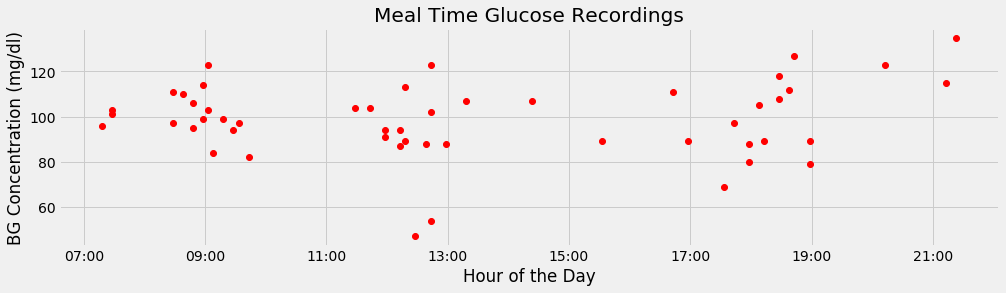

In [28]:
print "\n---------------------------------------"
print "\nAggregate all meals in one day chart to visualize meal timing pattern.\n"

from matplotlib import dates

df_P_all_clean_1day = copy.deepcopy(df_P_meals_w_deletion_v2)

d = datetime.datetime.today()
for i in range(len(df_P_all_clean_1day)):
    dt = df_P_all_clean_1day.Date[i].replace(year=d.year, month=d.month, day=d.day)    
    df_P_all_clean_1day.Date[i] = dt

fig = plt.figure(figsize= (15,15))
plt.subplots_adjust(hspace=0.5)

sub1 = fig.add_subplot(311)
sub1.set_xlabel('Hour of the Day')
sub1.set_ylabel('BG Concentration (mg/dl)')
sub1.set_title('Meal Time Glucose Recordings')
plt.plot_date(df_P_all_clean_1day.Date, df_P_all_clean_1day['mg/dL'], 'ro')  

xfmt = dates.DateFormatter('%H:%M')
#xfmt = dates.DateFormatter('%d-%m-%y %H:%M')
sub1.xaxis.set_major_formatter(xfmt)

plt.show()

## All preprocessing is complete!!! Now, data analysis.